In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
cells = pd.read_csv('data/cells_split_xyz_no_duplicates.csv', index_col=[0])
cell_types = cells['cell_type'].unique().tolist()
synapse_data = pd.read_csv('data/combined_synapse_data_rescaled.csv', index_col=[0])

print(f'Cells: {len(cells)}')
print(f'Cell types: {cell_types}')
print(f'Synapses: {len(synapse_data)}')

Cells: 57804
Cell types: ['23P', '4P', '6P-IT', '6P-CT', '5P-IT', '5P-NP', '5P-ET']
Synapses: 6822344


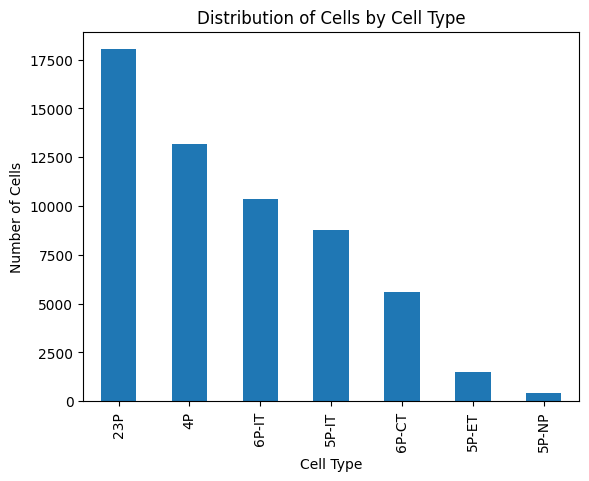

In [4]:
# Plot the distribution of the cells by cell type
cells['cell_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Cells by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.show()

In [5]:
old_displacements = pd.read_csv('deprecated/disp_and_dist.csv')
col_map = {'x':'x_diff', 'y':'y_diff', 'z':'z_diff'}
old_displacements = old_displacements.rename(columns=col_map)
old_displacements = old_displacements.drop(columns=['Unnamed: 0', 'magnitude'])
old_displacements.head()

,x_diff,y_diff,z_diff
0,-234.496,86.592,-47.92
1,-33.216,45.376,25.40
2,98.752,432.576,-43.64
3,31.552,-32.384,57.88
4,-17.472,-15.168,-61.68


In [6]:
print(len(old_displacements))

2832191


In [7]:
new_displacements = synapse_data[['x_diff', 'y_diff', 'z_diff']]
new_displacements.head()

,x_diff,y_diff,z_diff
0,-234.496,86.592,-47.92
1,-33.216,45.376,25.40
2,98.752,432.576,-43.64
3,31.552,-32.384,57.88
4,-17.472,-15.168,-61.68


In [8]:
# Check if the results from using the pandas technique are the same as manually looping through synapses
print(f'Results Valid? {old_displacements.equals(new_displacements[:2832191])}')

Results Valid? True


In [9]:
displacements = synapse_data[['x_diff', 'y_diff', 'z_diff']].to_numpy()
print(displacements.shape)

(6822344, 3)


In [10]:
# Step 0: Remove any displacements of 0 (for some reason I chose to be really thorough here)
self_connections1 = synapse_data[synapse_data['pre_pt_root_id'] == synapse_data['post_pt_root_id']]
self_connections = displacements[np.all(displacements == 0, axis=1)]
displacements = displacements[~np.all(displacements == 0, axis=1)]
print(f'Self connections method 1: {len(self_connections)}')
print(f'Self connections method 2: {len(self_connections1)}')
print(f'Non-self connections: {len(displacements)}')

Self connections method 1: 734840
Self connections method 2: 734840
Non-self connections: 6087504


In [11]:
# Step 1: Zero center the displacements
print(displacements.mean(axis=0))
print(np.linalg.norm(displacements.mean(axis=0)))
displacements -= displacements.mean(axis=0)
print(displacements.mean(axis=0))
print(np.linalg.norm(displacements.mean(axis=0)))

[ -4.85283127 -13.91486496   3.80666272]
15.220516390375165
[ 8.94204825e-12 -3.41462292e-12 -1.11043982e-12]
9.636023719909013e-12


In [12]:
# Step 2: Compute the covariance matrix
covariance_matrix = np.cov(displacements.T)
print(covariance_matrix)

[[16224.33333615  1915.71569831  -447.81910811]
 [ 1915.71569831 26411.84804587  2095.72793036]
 [ -447.81910811  2095.72793036  8207.61858998]]


In [13]:
# Step 3: Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
print(f'Eigenvalues: {eigenvalues}')

# Step 3.5: Sort the eigenvalues and eigenvectors in descending order
eigenvalues_sorted = np.sort(eigenvalues)[::-1]
eigenvectors_sorted = eigenvectors[:, eigenvalues.argsort()[::-1]]

# Step 4: Compute the explained variance
explained_variance = eigenvalues_sorted / eigenvalues_sorted.sum()
print(f'Explained Variance: {explained_variance}')

Eigenvalues: [26970.18009025 15957.96670147  7915.65318028]
Explained Variance: [0.5304517  0.31386259 0.15568571]


In [14]:
# Step 6: Correct skew in displacement data by multiplying by the inverse of the covariance matrix
displacements_corrected = np.matmul(np.linalg.inv(covariance_matrix), displacements.T).T

# Step 7: Compute the covariance matrix of the corrected displacements
covariance_matrix_corrected = np.cov(displacements_corrected.T)
print(covariance_matrix_corrected)

# Step 8: Compute the eigenvalues and eigenvectors of the corrected covariance matrix
eigenvalues_corrected, eigenvectors_corrected = np.linalg.eig(covariance_matrix_corrected)
print(f'Eigenvalues: {eigenvalues_corrected}')

[[ 6.23416567e-05 -4.89078093e-06  4.65025645e-06]
 [-4.89078093e-06  3.90284527e-05 -1.02323473e-05]
 [ 4.65025645e-06 -1.02323473e-05  1.24704466e-04]]
Eigenvalues: [1.26331962e-04 6.26646251e-05 3.70779875e-05]


In [15]:
# Step 9: Calculate the magnitude of the corrected displacements
mags = np.linalg.norm(displacements_corrected, axis=1)
mags_std = np.std(mags)
mags_mean = np.mean(mags)

# Step 10: Visualize

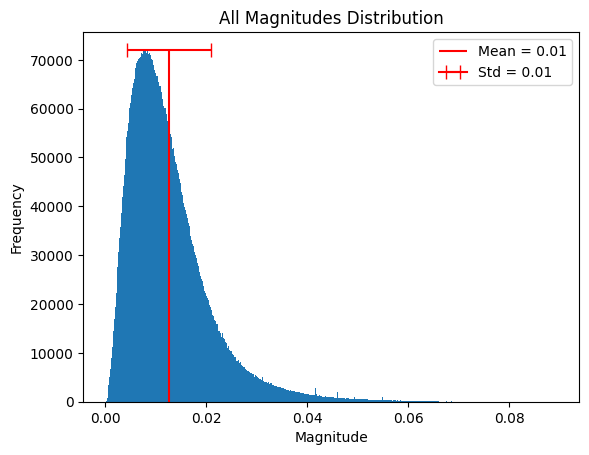

In [16]:
num_bins = 500
values, bins, _ = plt.hist(mags, bins=num_bins)
plt.vlines(mags_mean, 0, max(values), colors='r', label=f'Mean = {mags_mean:.2f}')
plt.errorbar(mags_mean, max(values), xerr=mags_std, color='r', capsize=5, label='Std = {:.2f}'.format(mags_std))
# plt.vlines(mags_mean + mags_std, 0, max(values), colors='g', label='Mean + Std')
# plt.vlines(mags_mean - mags_std, 0, max(values), colors='g', label='Mean - Std')
plt.title('All Magnitudes Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [17]:
# IMPORTANT: Here are the PDF and CDF of the magnitudes
mags_PDF = values / np.sum(values)
mags_CDF = np.cumsum(mags_PDF)

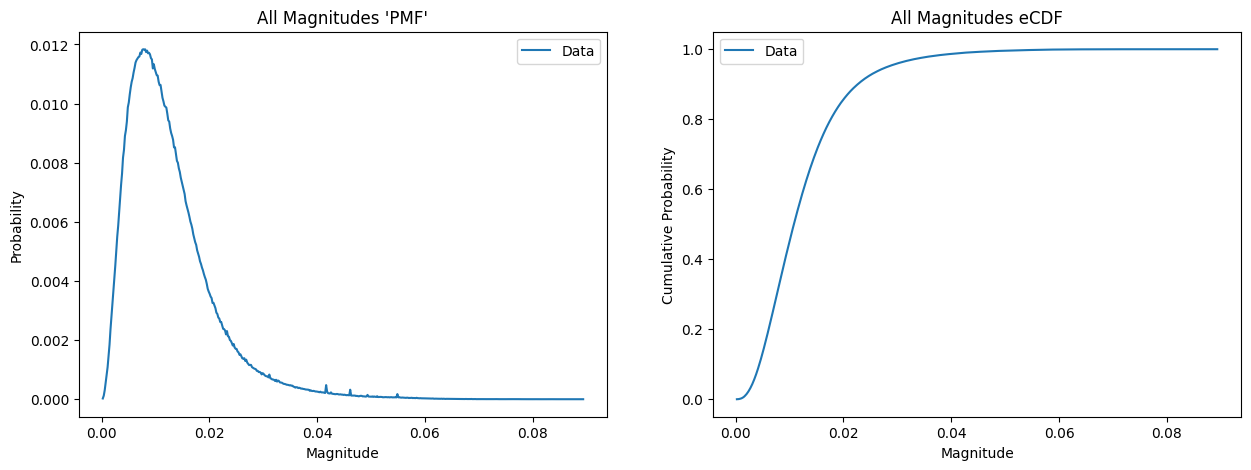

In [18]:
# Plot the PDF and CDF of the magnitudes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(bins[1:], mags_PDF, label='Data')
ax1.set_title('All Magnitudes \'PMF\'')
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Probability')
ax1.legend()

ax2.plot(bins[1:], mags_CDF, label='Data')
ax2.set_title('All Magnitudes eCDF')
ax2.set_xlabel('Magnitude')
ax2.set_ylabel('Cumulative Probability')
ax2.legend()
plt.show()

In [19]:
rayleigh_sig_sq = (1 / (2*len(mags))) * np.sum(mags**2)

dummy_mags = np.linspace(0,max(mags),len(mags_PDF))
rayleigh_pdf = (dummy_mags / rayleigh_sig_sq) * np.exp(-dummy_mags**2 / (2*rayleigh_sig_sq))
rayleigh_cdf = 1 - np.exp(-dummy_mags**2 / (2*rayleigh_sig_sq))

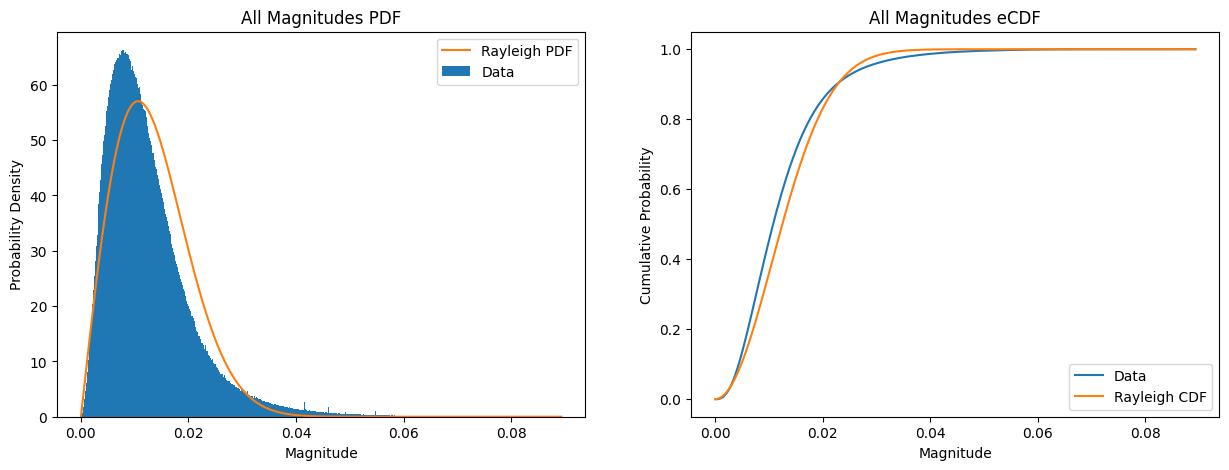

In [20]:
# Plot the PDF and CDF of the magnitudes compared to the Rayleigh distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(mags, bins=num_bins, label='Data', density=True)
ax1.plot(dummy_mags, rayleigh_pdf, label='Rayleigh PDF')
ax1.set_title('All Magnitudes PDF')
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Probability Density')
ax1.legend()

ax2.plot(bins[1:], mags_CDF, label='Data')
ax2.plot(dummy_mags, rayleigh_cdf, label='Rayleigh CDF')
ax2.set_title('All Magnitudes eCDF')
ax2.set_xlabel('Magnitude')
ax2.set_ylabel('Cumulative Probability')
ax2.legend()
plt.show()

In [21]:
# NEXT STAGE: Analyze the number of connections per neuron
# Step 1: Calculate the average number of connections per neuron
num_connections = len(synapse_data)
num_neurons = len(cells)
avg_num_connections = num_connections / num_neurons
print(f'Average Number of Connections per Neuron: {avg_num_connections}')

Average Number of Connections per Neuron: 118.02546536571863
